TClassTable::Add:0: RuntimeWarning: class timespec already in TClassTable
TClassTable::Add:0: RuntimeWarning: class reverse_iterator<__gnu_cxx::__normal_iterator<TString*,vector<TString> > > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class reverse_iterator<__gnu_cxx::__normal_iterator<string*,vector<string> > > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class reverse_iterator<__gnu_cxx::__normal_iterator<int*,vector<int> > > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<char*,string> already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<const char*,string> already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<TString*,vector<TString> > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<const TString*,vector<TString> > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gn

Welcome to JupyROOT 6.14/02


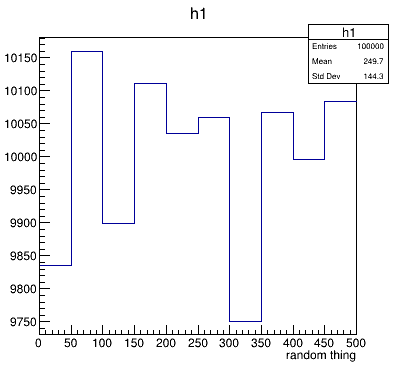

In [2]:
# A check to see if environment variables are setup correctly:
import sys, math, random, ROOT, uproot, torch
import numpy as np

h1 = ROOT.TH1F("h1", "h1", 10, 0, 500)
h1.GetXaxis().SetTitle("random thing")
h1.GetYaxis().SetTitle("events")

for x in range(100000):
    h1.Fill(random.randrange(0, 500))

c = ROOT.TCanvas("c", "canvas", 400, 400)
h1.Draw()
c.Draw()

In [8]:
# now do stuff:
zttFile = ROOT.TFile("ztt_Output.root")
signal_tree = zttFile.Get("tauROI")

signal_entries = signal_tree.GetEntries()
print(signal_entries)

<ROOT.TTree object ("tauROI") at 0x55737997fd70>
17232


In [10]:
MB80File = ROOT.TFile("output_MB80.root")
background_tree = MB80File.Get("mytree")

background_entries = background_tree.GetEntries()
print(background_entries)

69049
